# Hug and Hop

In [1]:
import numpy as np
from scipy.stats import multivariate_normal
import matplotlib.pyplot as plt
from utils import logp as logp_scale
from Zappa.zappa import zappa_sampling_multivariate, zappa_sampling
from Zappa.ZappaStore import Zappa
from Manifolds.RotatedEllipse import RotatedEllipse
from utils import quick_MVN_scatter, MVN_scatters, prep_contour
from numpy.random import rand
from numpy.linalg import norm, solve, inv, det
from scipy.optimize import fsolve, root
from Manifolds.Manifold import Manifold
from tangential_hug_functions import Hug, HugTangential, NoAR, GradientHug
from utils import quick_3d_scatter, quick_3d_scatters, quick_MVN_marginals
import plotly.graph_objects as go
from HugHop.StandardHugHop import HugHop

#### Target MVN

In [2]:
mu = np.zeros(2)
Sigma = np.array([[1.0, 0.99], [0.99, 2.0]])
target = multivariate_normal(mu, Sigma)
logpi = target.logpdf
grad_log_pi = lambda xy: - solve(Sigma, xy)
q = multivariate_normal(np.zeros(2), np.eye(2))
x0 = target.rvs()

#### Settings

In [3]:
T = 1.0
B = 5
n = 1
N = 100000
lam = 2.0 #0.3 #1.5
k = 0.25 #0.25
alpha=0.9

#### Hug and Hop

In [4]:
def Hop(x, lam, k, logpi, grad_log_pi):
    d = len(x)
    # Compute matrix square root
    mu_sq = k * lam
    mu = np.sqrt(mu_sq)
    lam_sq = lam**2
    # Compute normalized gradient at x
    gx = grad_log_pi(x)
    ngx = norm(gx)
    ghatx = gx / ngx
    # Sample from standard MVN
    u = multivariate_normal(np.zeros(d), np.eye(d)).rvs()
    # Transform to new sample
    y = x + ((mu*u + (lam - mu) * ghatx * (ghatx @ u)) / np.sqrt(max(1.0, ngx**2)))
    # Compute stuff at y
    gy = grad_log_pi(y)
    ngy = norm(gy)
    # Acceptance probability
    logr = logpi(y) - logpi(x) 
    logr += d * (np.log(ngy) - np.log(ngx))
    logr -= (norm(y - x)**2) * (ngy**2 - ngx**2) / (2*mu_sq)
    logr -= 0.5 * (((y - x) @ gy)**2 - ((y - x) @ gx)**2) * ((1 / lam_sq) - (1 / mu_sq))
    # Accept or reject
    if np.log(np.random.rand()) <= min(0, logr):
        # Accept
        return y, 1.0
    else:
        # Reject - stay where you are
        return x, 0.0

In [5]:
def run_hug_hop(x0, T, B, lam, k, q, logpi, grad_log_pi):
    """Runs Hug & Hop."""
    samples = x = x0
    ahug = np.zeros(N)
    ahop = np.zeros(N)
    for _ in range(N):
        out_hug, acc_hug = Hug(x, T, B, 1, q, logpi, grad_log_pi)
        x_hug, ahug[_] = out_hug[-1], acc_hug
        x, acc_hop = Hop(x_hug, lam, k, logpi, grad_log_pi)
        ahop[_] = acc_hop
        samples = np.vstack((samples, x_hug, x))
    return samples, ahug, ahop
samples1, ahug, ahop = run_hug_hop(x0, T, B, lam, k, q, logpi, grad_log_pi)

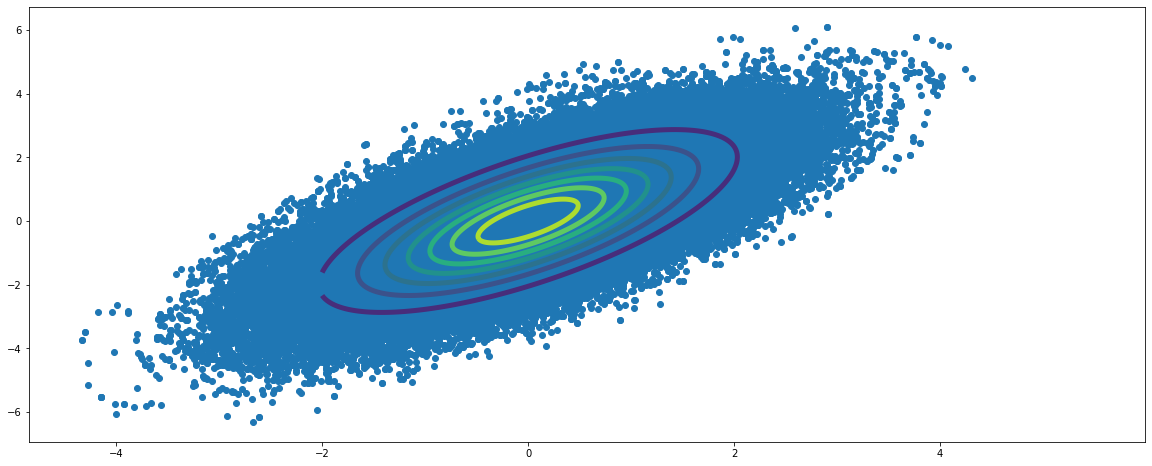

In [6]:
quick_MVN_scatter(samples1, target)

In [7]:
print('Hug: {:.3}%'.format(100 * np.sum(ahug) / N))
print('Hop: {:.3}%'.format(100 * np.sum(ahop) / N))

Hug: 99.7%
Hop: 43.0%


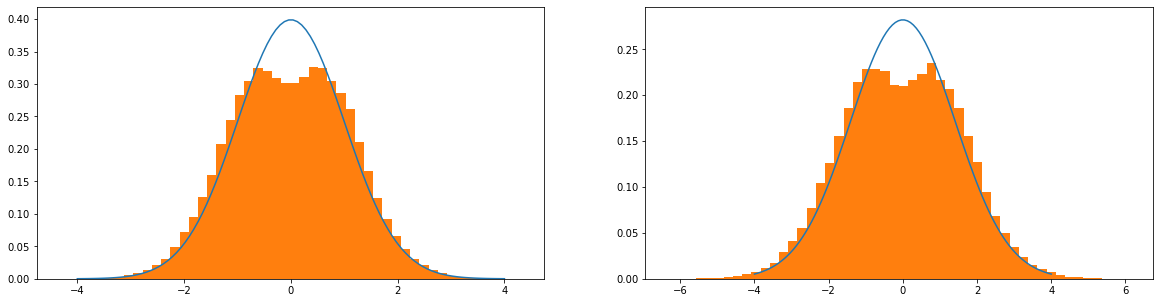

In [8]:
quick_MVN_marginals(samples1, target)

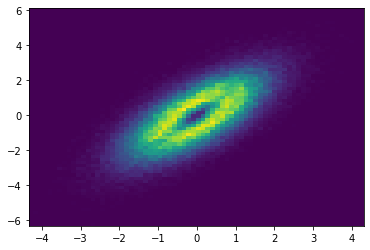

In [48]:
_ = plt.hist2d(*samples1.T, density=True, bins=70)

#### THUG and Hop

In [26]:
def run_thug_hop(x0, T, B, N, lam, k, alpha, q, logpi, grad_log_pi):
    samples = x = x0
    athug = np.zeros(N)
    ahop = np.zeros(N)
    for _ in range(N):
        out_thug, acc_thug = HugTangential(x, T, B, 1, alpha, q, logpi, grad_log_pi)
        x_thug, athug[_] = out_thug[-1], acc_thug
        x, acc_hop = Hop(x_thug, lam, k, logpi, grad_log_pi)
        ahop[_] = acc_hop
        samples = np.vstack((samples, x_thug, x))
    return samples, athug, ahop

samples2, athug, ahop2 = run_thug_hop(x0, T, B, N, lam, k, alpha, q, logpi, grad_log_pi)

In [10]:
print('THug: {:.3}%'.format(100 * np.sum(athug) / N))
print('Hop: {:.3}%'.format(100 * np.sum(ahop2) / N))

THug: 78.6%
Hop: 42.8%


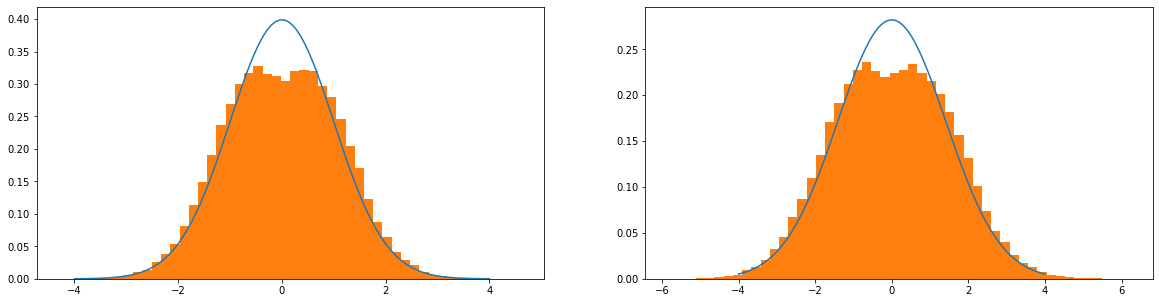

In [11]:
quick_MVN_marginals(samples2, target)

# Gradient Hug

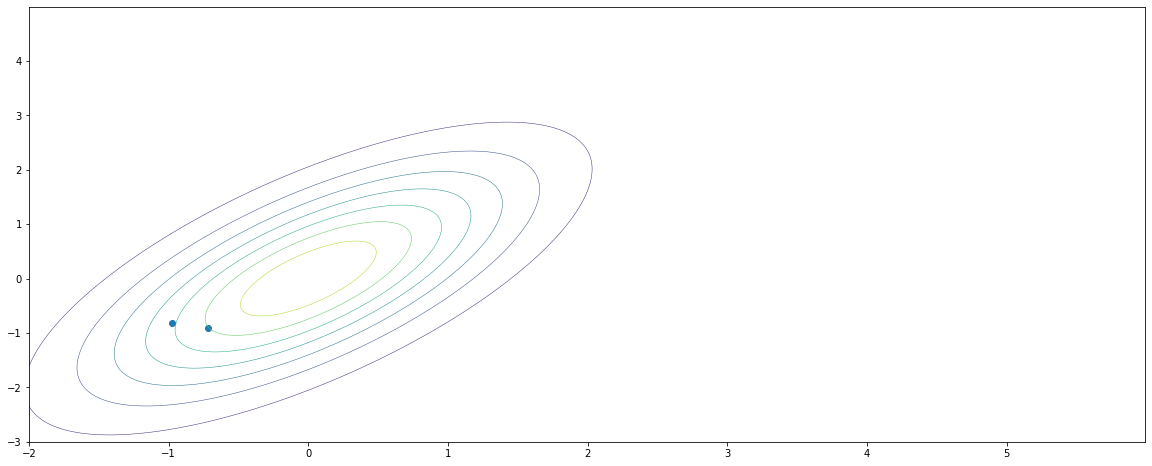

In [20]:
xghug, _ = GradientHug(x0, 1.0, q, logpi, grad_log_pi)
ss = np.vstack((x0, xghug))
quick_MVN_scatter(ss, target, lw=0.5)

In [25]:
def run_thug_gradient(x0, T, B, N, alpha, q, logpi, grad_log_pi):
    samples = x = x0
    athug = np.zeros(N)
    aghug= np.zeros(N)
    for _ in range(N):
        out_thug, acc_thug = HugTangential(x, T, B, 1, alpha, q, logpi, grad_log_pi)
        x_thug, athug[_] = out_thug[-1], acc_thug
        x, acc_ghug = GradientHug(x_thug, T/B, q, logpi, grad_log_pi)
        aghug[_] = acc_ghug
        samples = np.vstack((samples, x_thug, x))
    return samples, athug, aghug

samples3, athug3, aghug = run_thug_gradient(x0, T, B, N, alpha, q, logpi, grad_log_pi)

In [22]:
print('THug: {:.3}%'.format(100 * np.sum(athug3) / N))
print('GHug: {:.3}%'.format(100 * np.sum(aghug) / N))

THug: 74.2%
GHug: 88.6%


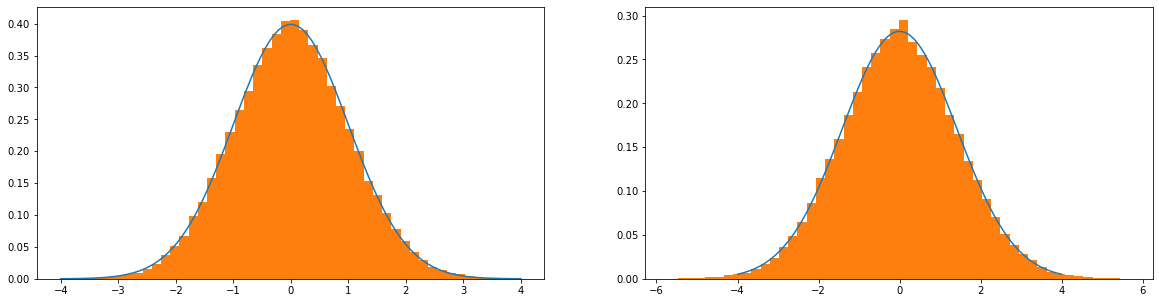

In [23]:
quick_MVN_marginals(samples3, target)

# Targeting a mixture of gaussians

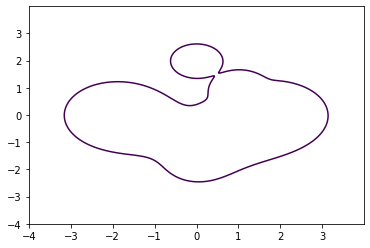

In [24]:
### Parameters of Mixture
# Means
mus = np.array([
    [0, 0],
    [2, 0],
    [0, 2],
    [-2, 0],
    [0, -2],
    [1, 1]
])
# Covariances
Sigmas = np.stack([
    3.0 * np.eye(2),
    1.0 * np.eye(2),
    0.05 * np.eye(2),
    0.5 * np.eye(2),
    2.0 * np.eye(2),
    0.05 * np.eye(2)
])
# Mixture coefficients are all the same
d = mus.shape[0]
coefs = np.repeat(1/d, d)

# Gaussian Components
distributions = [multivariate_normal(mu, Sigma) for (mu, Sigma) in zip(mus, Sigmas)]

# Mixture, log mixture, grad of log mixture
MG = lambda xy: np.sum(np.vstack([c * MVN.pdf(xy)  for (c, MVN) in zip(coefs, distributions)]), axis=0)
logpi = lambda xy: np.log(MG(xy))
grad_log_pi = lambda xy: (1 / MG(xy)) * np.sum(np.vstack([- c * multivariate_normal(mu, Sigma).pdf(xy) * solve(Sigma, xy - mu) for (c, mu, Sigma) in zip(coefs, mus, Sigmas)]), axis=0)

# Find an odd contour
z = 0.016   # Sharp Turn: 0.016, Softer Turn: 0.004
plt.contour(*prep_contour([-4, 4], [-4, 4], 0.01, MG), levels=[z])
plt.show()

In [27]:
# Find starting point on contour
starting_guess = np.array([0.0, -2.5]) # Near Hook: np.array([-0.1, 2.5])
x0 = fsolve(lambda xy: np.append(MG(xy) - z, 0), starting_guess)

In [37]:
N = 50000

In [38]:
samples2, athug, ahop2 = run_thug_hop(x0, T, B, N, lam, k, alpha, q, logpi, grad_log_pi)

In [39]:
samples3, athug3, aghug = run_thug_gradient(x0, T, B, N, alpha, q, logpi, grad_log_pi)

In [41]:
print('Hop: {:.3}%'.format(100 * np.sum(ahop2) / N))
print('GHug: {:.3}%'.format(100 * np.sum(aghug) / N))

Hop: 51.0%
GHug: 84.2%


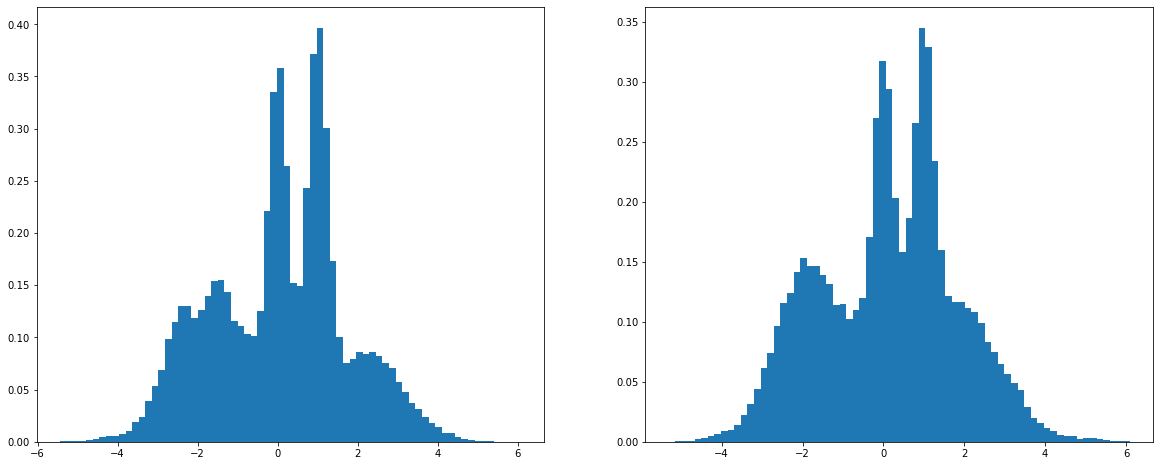

In [40]:
fig, ax = plt.subplots(ncols=2, figsize=(20, 8))
_ = ax[0].hist(samples2[:, 0], density=True, bins=70)
_ = ax[1].hist(samples3[:, 0], density=True, bins=70)

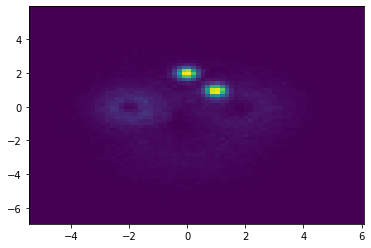

In [45]:
_ = plt.hist2d(*samples2.T, density=True, bins=70)

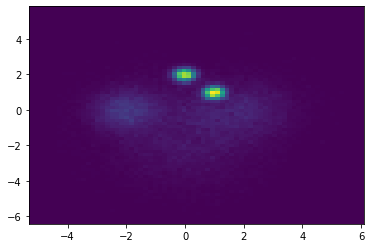

In [46]:
_ = plt.hist2d(*samples3.T, density=True, bins=70)

In [49]:
%timeit GradientHug(x0, T/B, q, logpi, grad_log_pi)

1.06 ms ± 6.12 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [50]:
%timeit Hop(x0, lam, k, logpi, grad_log_pi)

1.85 ms ± 13.3 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
